# Evaluating Parameter Interdependence

Test run on ________ by ________. Using SD PCB Interface Board serial number 002, SD PCB Driver Board serial number 002, and SD PCB Video Board serial number 001.

### Set up the FPE

Remember that whenever you power-cycle the Observatory Simulator, you should set preload=True below.

When you are running this notbook and it has not been power cycled, you should set preload=False.

In [28]:
from tessfpe.dhu.fpe import FPE
from tessfpe.dhu.unit_tests import check_house_keeping_voltages
import time
fpe1 = FPE(1, debug=False, preload=False, FPE_Wrapper_version='6.1.1')
print fpe1.version
time.sleep(.01)
if check_house_keeping_voltages(fpe1):
    print "Wrapper load complete. Interface voltages OK."

Observatory Simulator Version 1.6c - Oct  8 2015 11:55:03
Wrapper load complete. Interface voltages OK.


Set the operating parameters to the default values:

In [29]:
def set_fpe_defaults(fpe):
    "Set the FPE to the default operating parameters, and outputs a table of the default values"
    defaults = {}
    for k in range(len(fpe.ops.address)):
        if fpe.ops.address[k] is None:
            continue
        fpe.ops.address[k].value = fpe.ops.address[k].default
        defaults[fpe.ops.address[k].name] = fpe.ops.address[k].default
    return defaults

Get, sort, and print the default operating parameters:

In [30]:
from tessfpe.data.operating_parameters import operating_parameters

In [31]:
for k in sorted(operating_parameters.keys()):
    v = operating_parameters[k]
    print k, ":", v["default"], v["unit"]

ccd1_backside : 0.0 V
ccd1_input_diode_high : 12.0 V
ccd1_input_diode_low : 12.0 V
ccd1_input_gate_1 : -3.0 V
ccd1_input_gate_2 : -3.0 V
ccd1_output_drain_a_offset : 8.0 V
ccd1_output_drain_b_offset : 8.0 V
ccd1_output_drain_c_offset : 8.0 V
ccd1_output_drain_d_offset : 8.0 V
ccd1_output_gate : -1.0 V
ccd1_parallel_high_offset : 0.0 V
ccd1_parallel_low : -8.0 V
ccd1_reset_drain : 12.0 V
ccd1_reset_high : 3.0 V
ccd1_reset_low_offset : -3.0 V
ccd1_scupper : 12.0 V
ccd1_serial_high : 4.0 V
ccd1_serial_low_offset : -6.0 V
ccd1_substrate : -40.0 V
ccd2_backside : 0.0 V
ccd2_input_diode_high : 12.0 V
ccd2_input_diode_low : 12.0 V
ccd2_input_gate_1 : -3.0 V
ccd2_input_gate_2 : -3.0 V
ccd2_output_drain_a_offset : 8.0 V
ccd2_output_drain_b_offset : 8.0 V
ccd2_output_drain_c_offset : 8.0 V
ccd2_output_drain_d_offset : 8.0 V
ccd2_output_gate : -1.0 V
ccd2_parallel_high_offset : 0.0 V
ccd2_parallel_low : -8.0 V
ccd2_reset_drain : 12.0 V
ccd2_reset_high : 3.0 V
ccd2_reset_low_offset : -3.0 V
ccd2_s

Take a number of sets of housekeeping data, with one operating parameter varying across it's control range, then repeat for every operating parameter:

In [32]:
def get_base_name(name):
    import re
    if '_offset' not in name:
        return None
    offset_name = name
    derived_parameter_name = name.replace('_offset', '')
    base_name = None
    if 'low' in derived_parameter_name:
        base_name = derived_parameter_name.replace('low', 'high')            
    if 'high' in derived_parameter_name:
        base_name = derived_parameter_name.replace('high', 'low')
    if 'output_drain' in derived_parameter_name:
            base_name = re.sub(r'output_drain_._offset$', 'reset_drain', offset_name)
    return base_name

In [33]:
def get_derived_parameter_name(name):
    if '_offset' not in name:
        return None
    offset_name = name
    return name.replace('_offset', '')

In [34]:
data = {}

base_steps = 15

offset_steps = 5

set_fpe_defaults(fpe1)
for i in range(base_steps,0,-1):
    for j in range(offset_steps, 0, -1):
        for k in range(len(fpe1.ops.address)):
            # If there's no operating parameter to set, go on to the next one
            if fpe1.ops.address[k] is None:
                continue
            name = fpe1.ops.address[k].name
            base_name = get_base_name(name)
            derived_parameter_name = get_derived_parameter_name(name)
            # If there's no derived parameter reflecting this parameter, go on to the next one
            if derived_parameter_name is None:
                continue
            offset_name = name
            base_low = fpe1.ops[base_name].low
            base_high = fpe1.ops[base_name].high
            offset_low = fpe1.ops[offset_name].low
            offset_high = fpe1.ops[offset_name].high
            base_value = base_low + i / float(base_steps) * (base_high - base_low)
            fpe1.ops[base_name].value = base_value
            fpe1.ops[offset_name].value = offset_low + j / float(offset_steps) * (offset_high - offset_low)
        fpe1.ops.send()
        analogue_house_keeping = fpe1.house_keeping["analogue"]
        for k in range(len(fpe1.ops.address)):
            # If there's no operating parameter to set, go on to the next one
            if fpe1.ops.address[k] is None:
                continue
            name = fpe1.ops.address[k].name
            base_name = get_base_name(name)
            derived_parameter_name = get_derived_parameter_name(name)
            if derived_parameter_name is None:
                continue
            if derived_parameter_name not in data:
                data[derived_parameter_name] = {}
            offset_name = name
            base_low = fpe1.ops[base_name].low
            base_high = fpe1.ops[base_name].high
            offset_low = fpe1.ops[offset_name].low
            offset_high = fpe1.ops[offset_name].high
            base_value = base_low + i / float(base_steps) * (base_high - base_low)
            if base_value not in data[derived_parameter_name]:
                data[derived_parameter_name][base_value] = {"X": [], "Y": []}
            data[derived_parameter_name][base_value]["X"].append(fpe1.ops[base_name].value + 
                                                                 fpe1.ops[offset_name].value)
            data[derived_parameter_name][base_value]["Y"].append(analogue_house_keeping[derived_parameter_name])

### Set up to plot:

In [35]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
import pylab

### Plot selected data:

In [36]:
def get_range_square(X,Y):
    return [min(X + Y)-1, max(X + Y)+1]

ccd1_output_drain_a
1.0


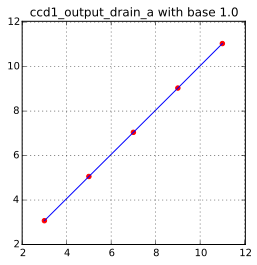

2.0


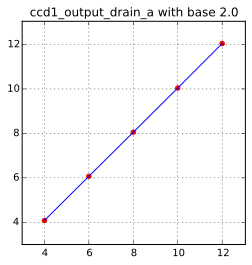

3.0


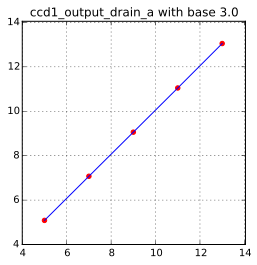

4.0


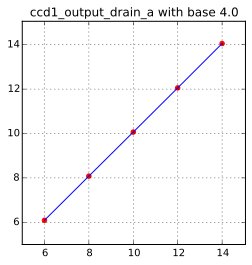

5.0


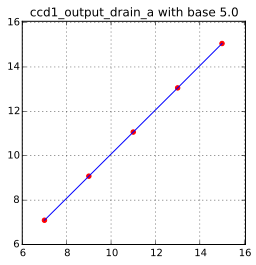

6.0


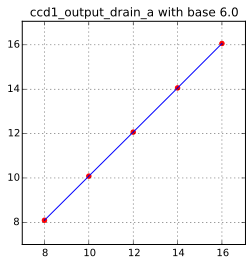

7.0


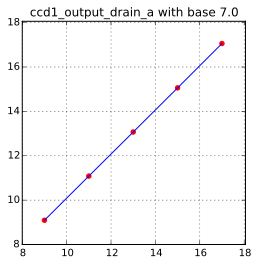

8.0


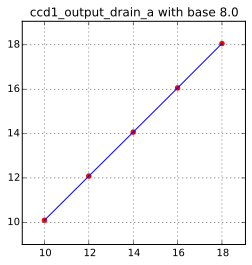

9.0


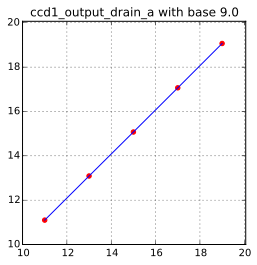

10.0


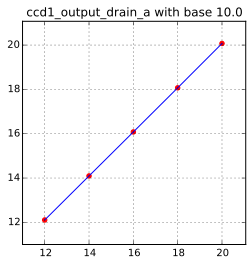

11.0


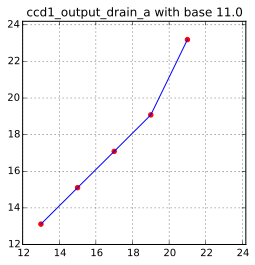

12.0


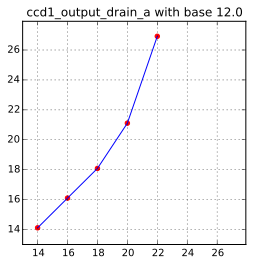

13.0


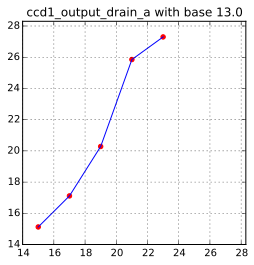

14.0


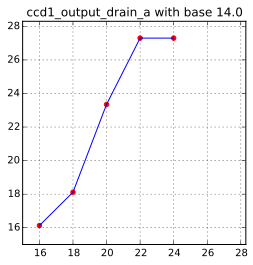

15.0


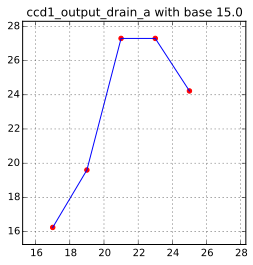

ccd1_output_drain_b
1.0


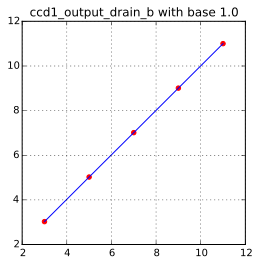

2.0


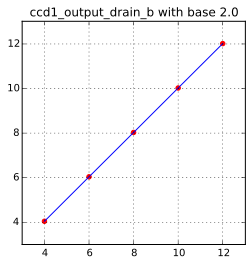

3.0


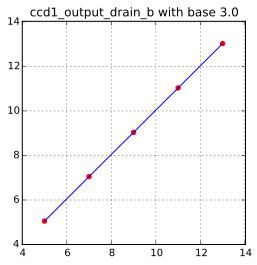

4.0


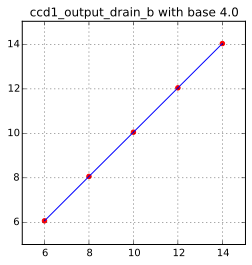

5.0


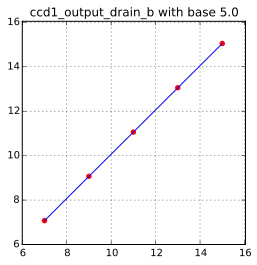

6.0


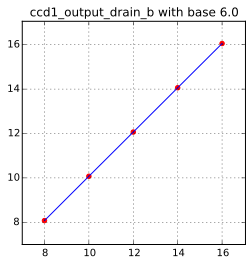

7.0


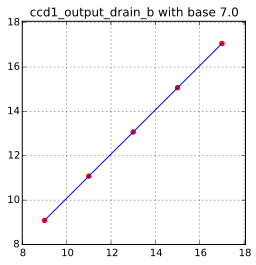

8.0


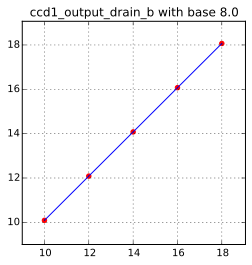

9.0


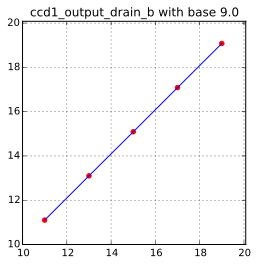

10.0


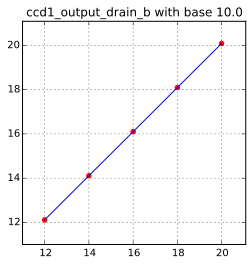

11.0


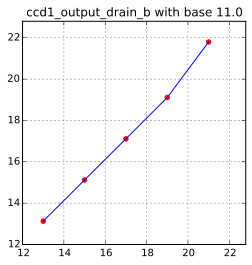

12.0


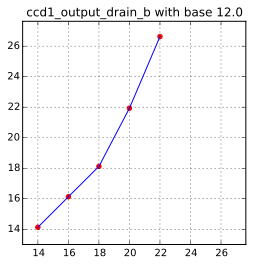

13.0


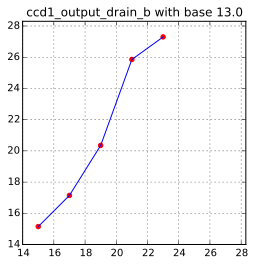

14.0


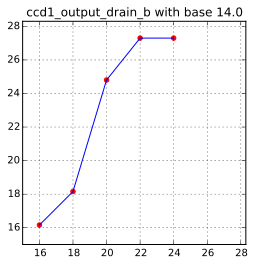

15.0


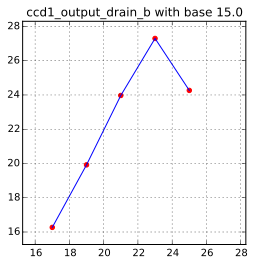

ccd1_output_drain_c
1.0


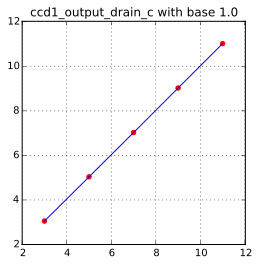

2.0


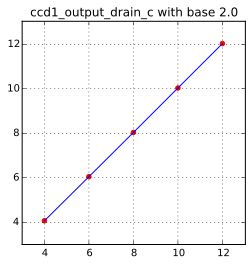

3.0


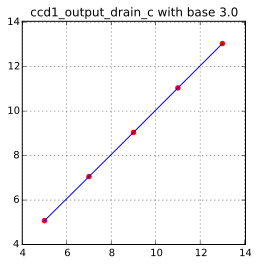

4.0


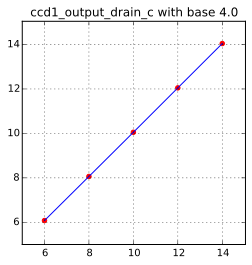

5.0


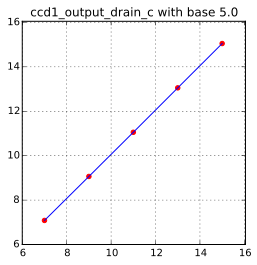

6.0


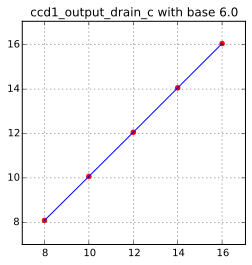

7.0


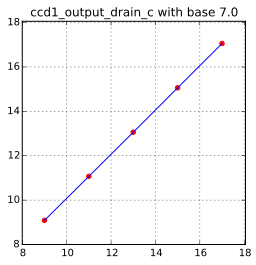

8.0


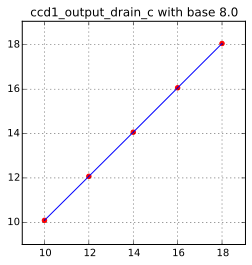

9.0


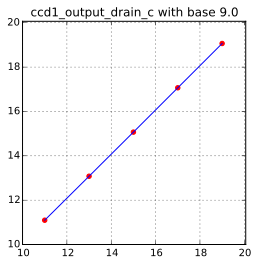

10.0


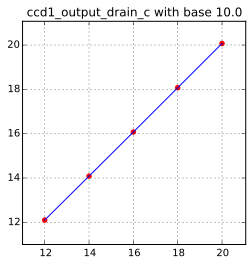

11.0


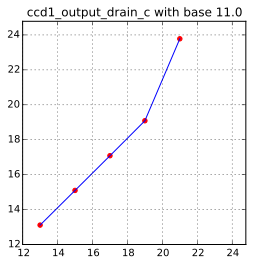

12.0


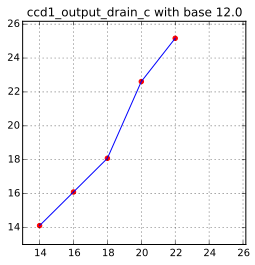

13.0


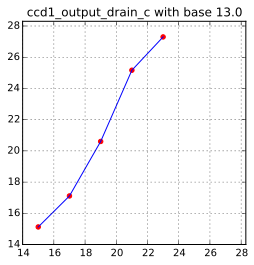

14.0


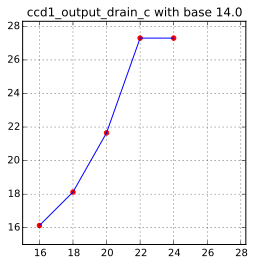

15.0


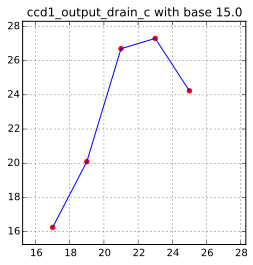

ccd1_output_drain_d
1.0


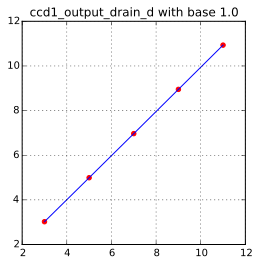

2.0


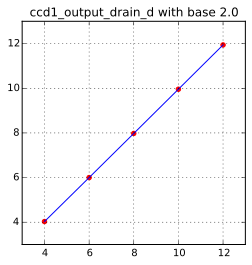

3.0


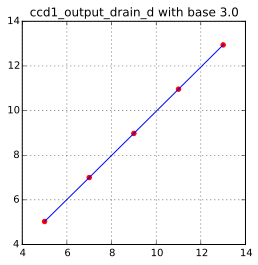

4.0


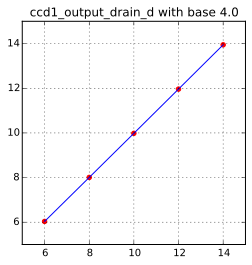

5.0


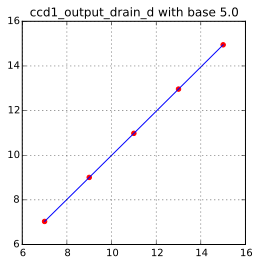

6.0


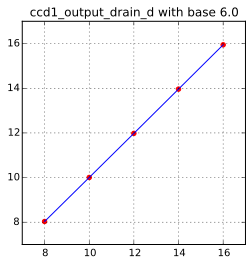

7.0


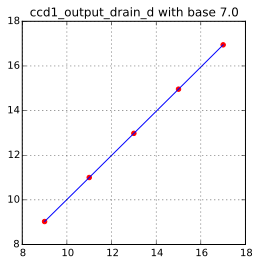

8.0


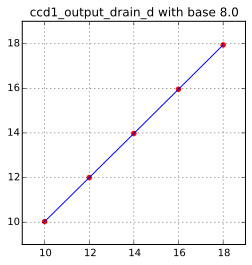

9.0


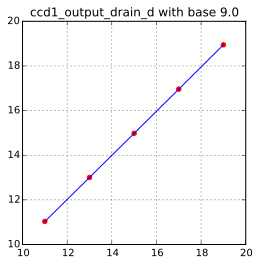

10.0


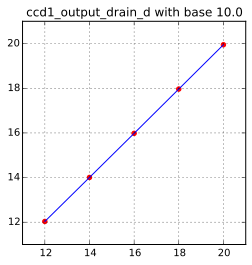

11.0


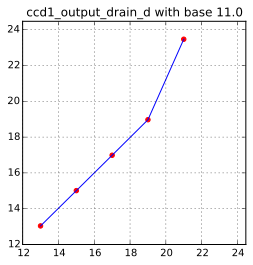

12.0


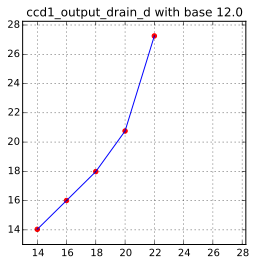

13.0


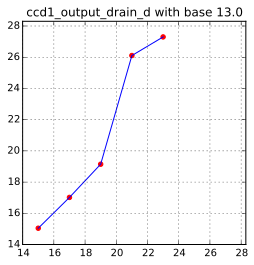

14.0


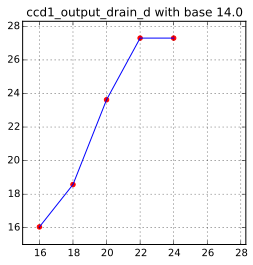

15.0


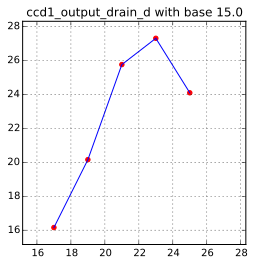

ccd1_parallel_high
-13.2


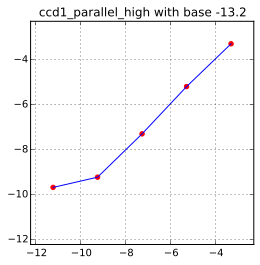

-12.32


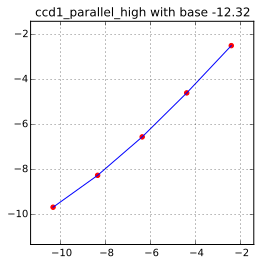

-11.44


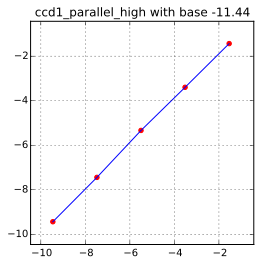

-10.56


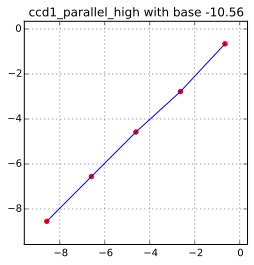

-9.68


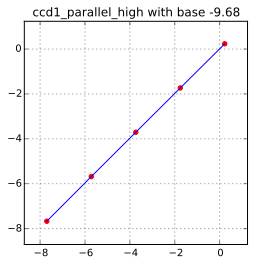

-8.8


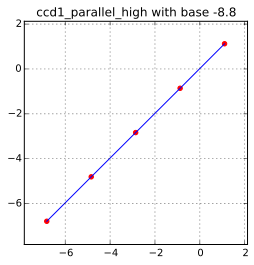

-7.92


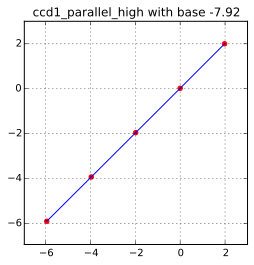

-7.04


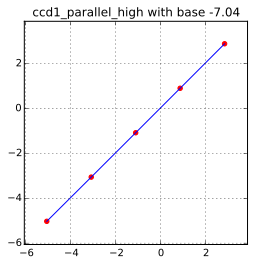

-6.16


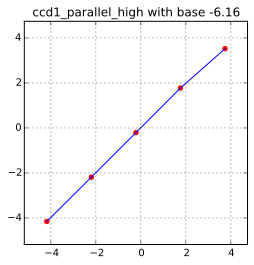

-5.28


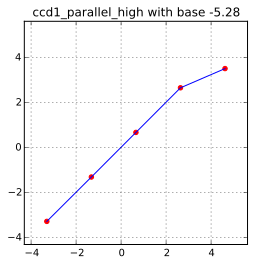

-4.4


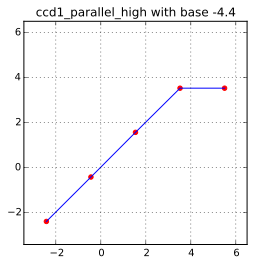

-3.52


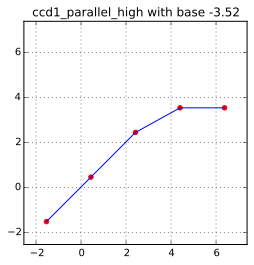

-2.64


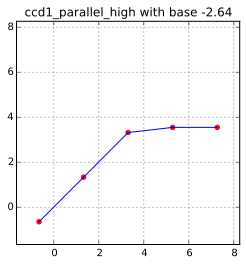

-1.76


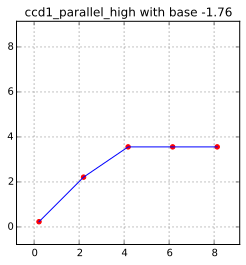

-0.88


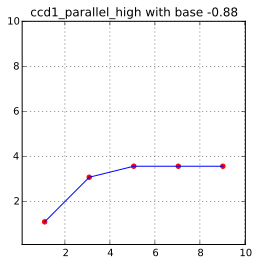

ccd1_reset_low
-10.3


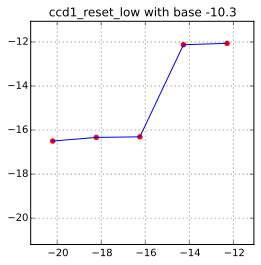

-8.61333333333


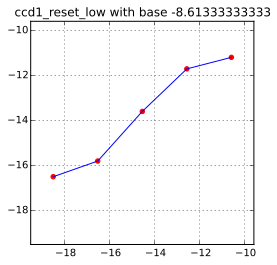

-6.92666666667


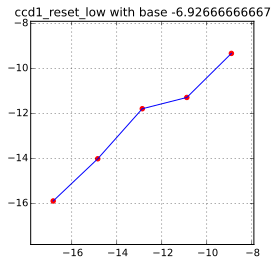

-5.24


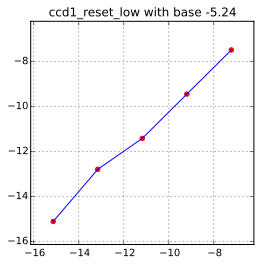

-3.55333333333


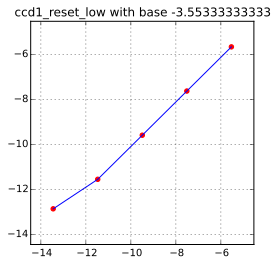

-1.86666666667


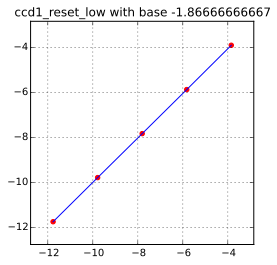

-0.18


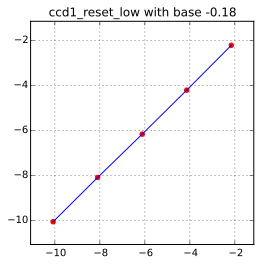

1.50666666667


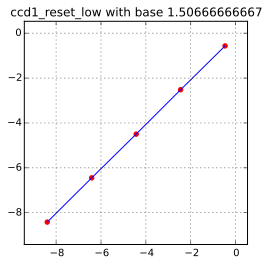

3.19333333333


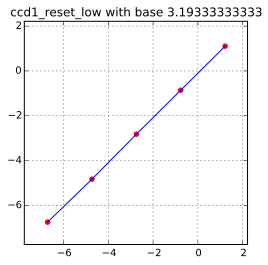

4.88


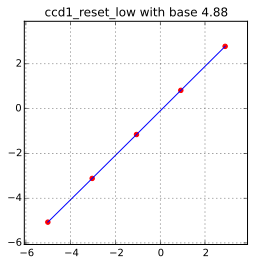

6.56666666667


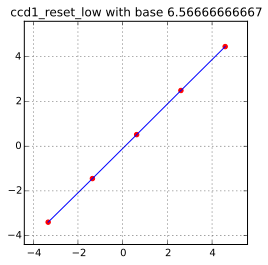

8.25333333333


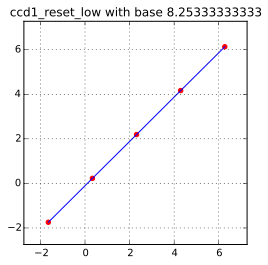

9.94


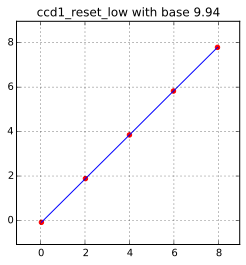

11.6266666667


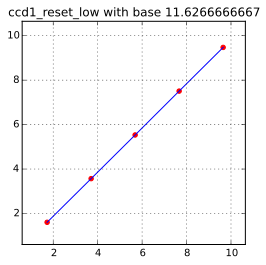

13.3133333333


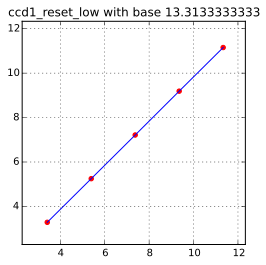

ccd1_serial_low
-10.3


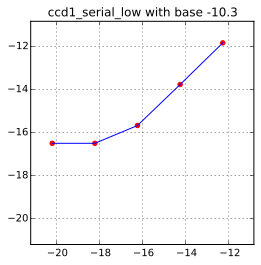

-8.61333333333


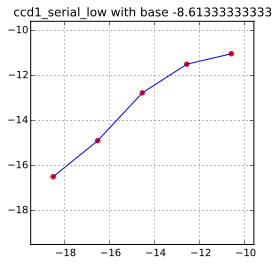

-6.92666666667


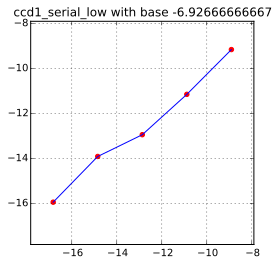

-5.24


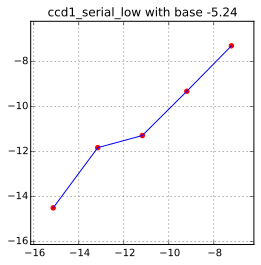

-3.55333333333


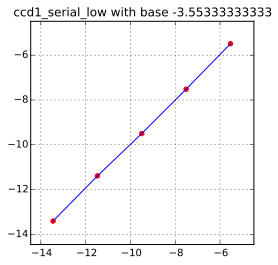

-1.86666666667


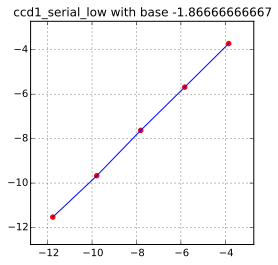

-0.18


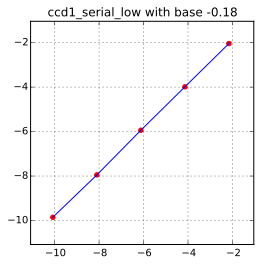

1.50666666667


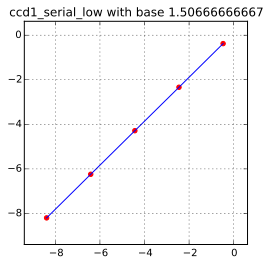

3.19333333333


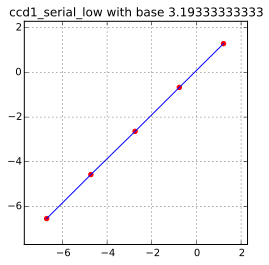

4.88


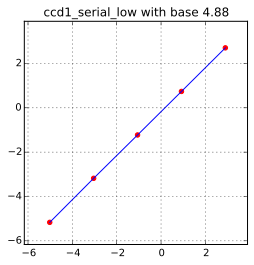

6.56666666667


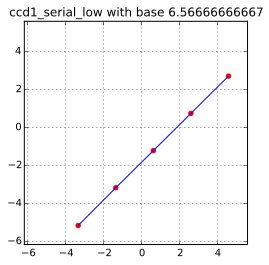

8.25333333333


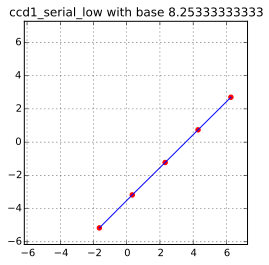

9.94


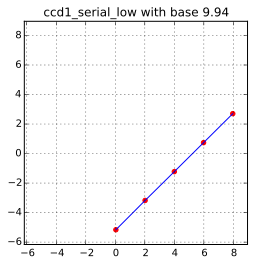

11.6266666667


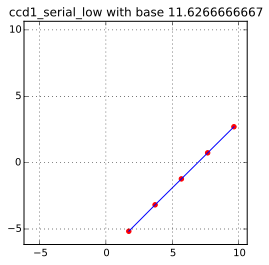

13.3133333333


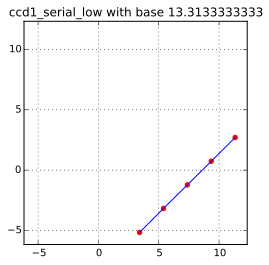

ccd2_output_drain_a
1.0


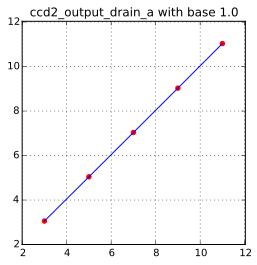

2.0


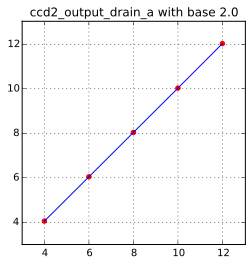

3.0


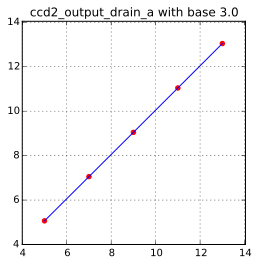

4.0


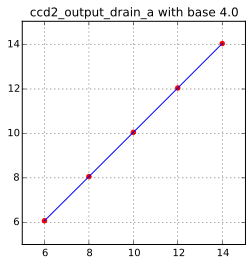

5.0


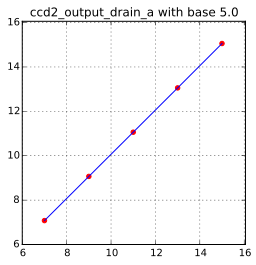

6.0


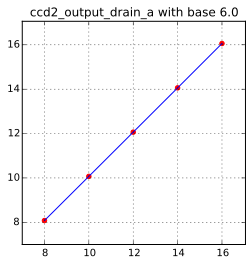

7.0


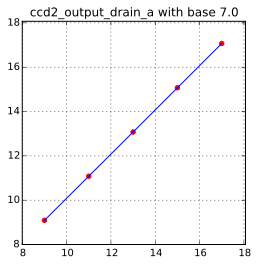

8.0


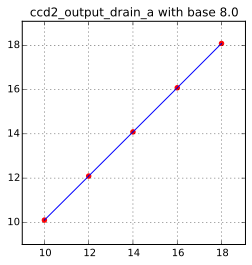

9.0


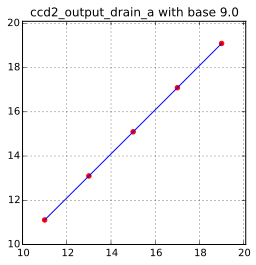

10.0


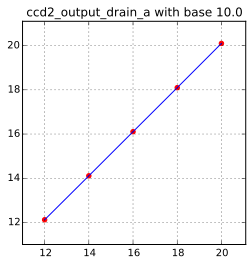

11.0


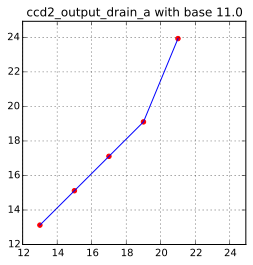

12.0


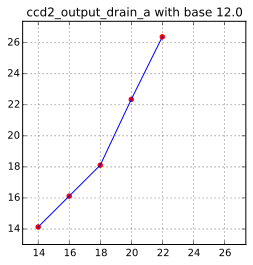

13.0


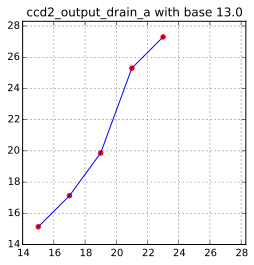

14.0


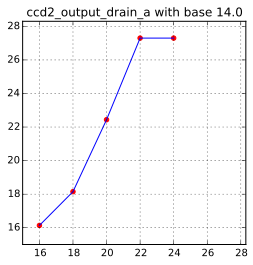

15.0


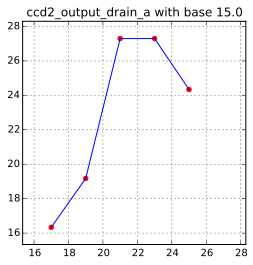

ccd2_output_drain_b
1.0


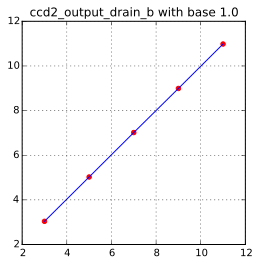

2.0


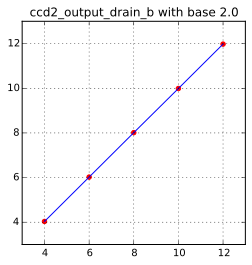

3.0


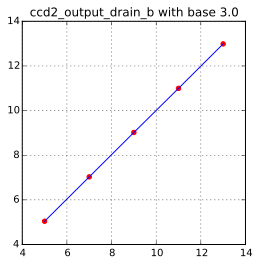

4.0


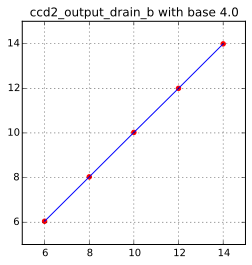

5.0


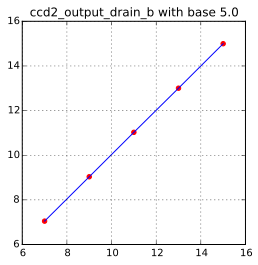

6.0


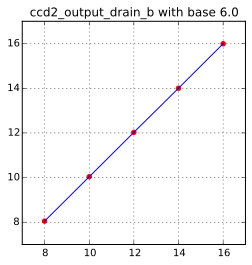

7.0


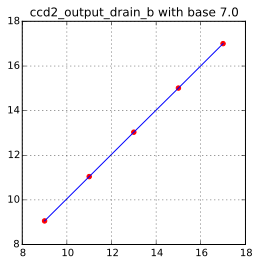

8.0


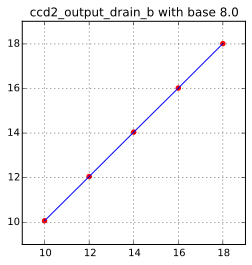

9.0


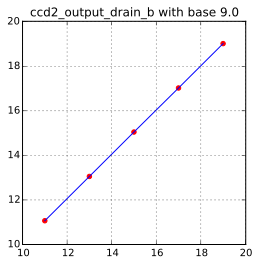

10.0


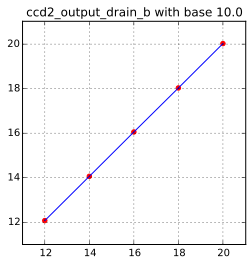

11.0


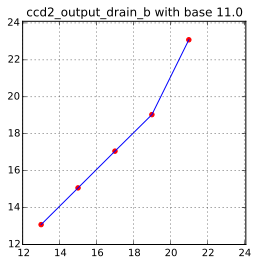

12.0


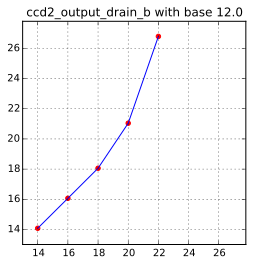

13.0


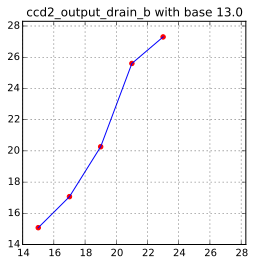

14.0


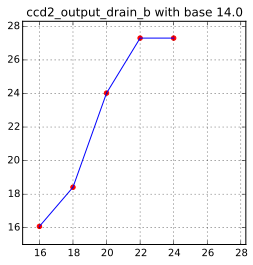

15.0


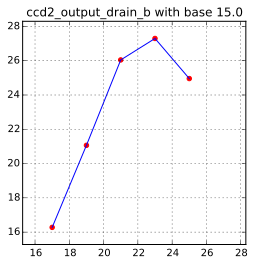

ccd2_output_drain_c
1.0


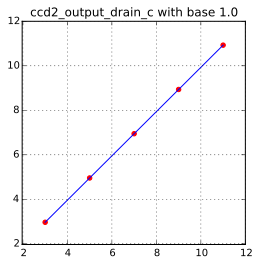

2.0


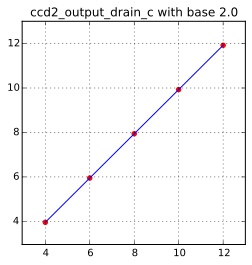

3.0


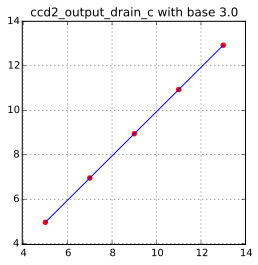

4.0


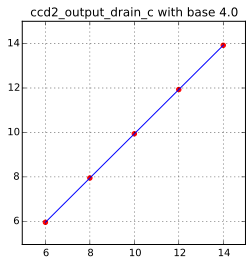

5.0


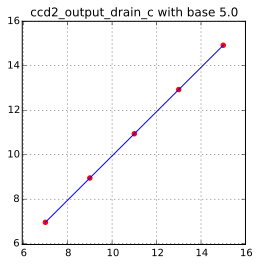

6.0


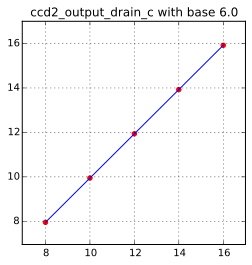

7.0


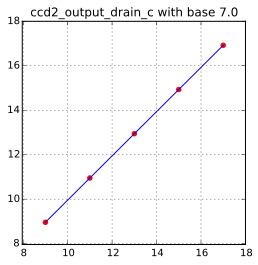

8.0


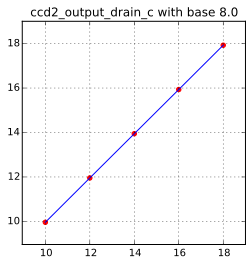

9.0


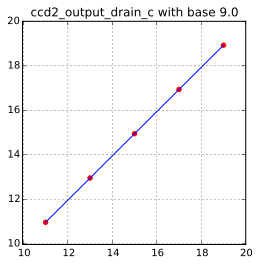

10.0


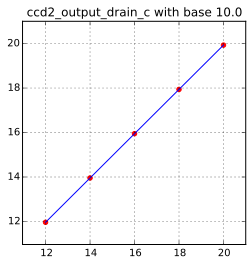

11.0


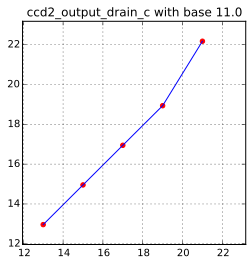

12.0


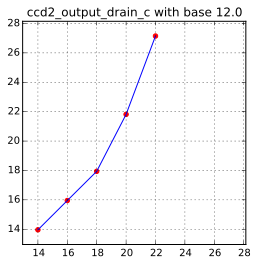

13.0


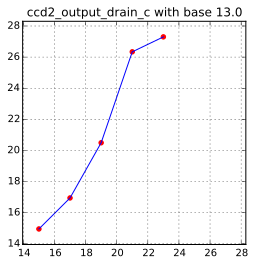

14.0


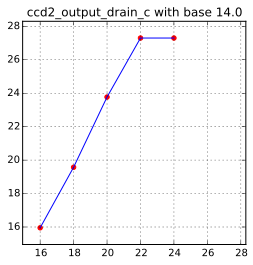

15.0


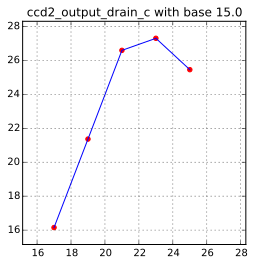

ccd2_output_drain_d
1.0


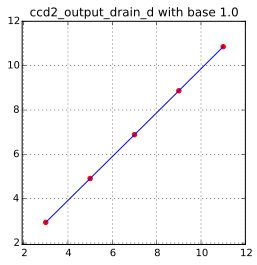

2.0


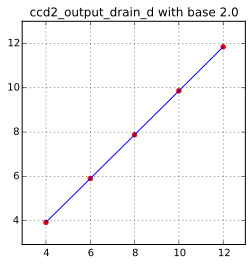

3.0


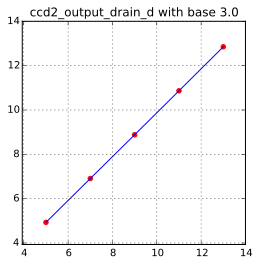

4.0


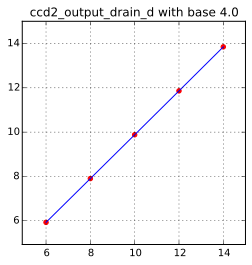

5.0


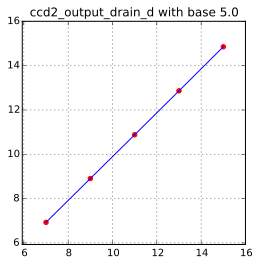

6.0


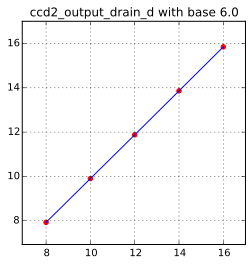

7.0


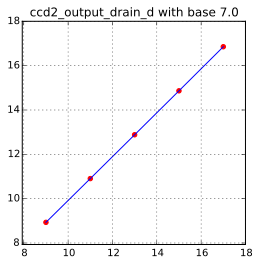

8.0


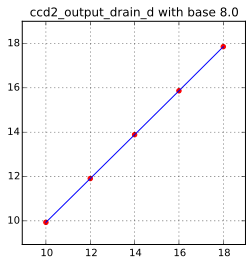

9.0


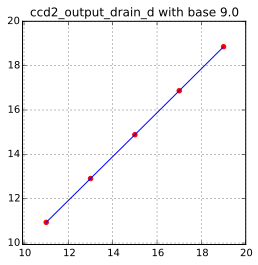

10.0


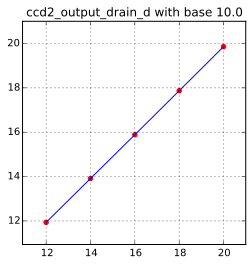

11.0


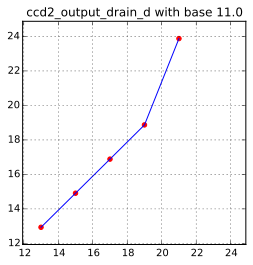

12.0


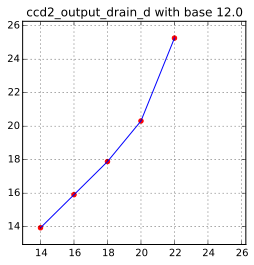

13.0


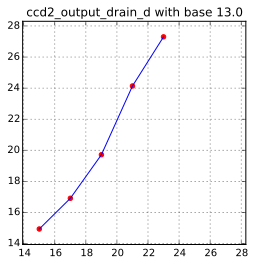

14.0


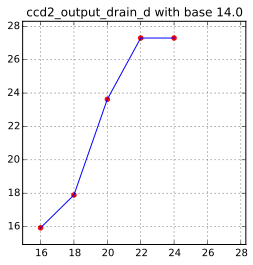

15.0


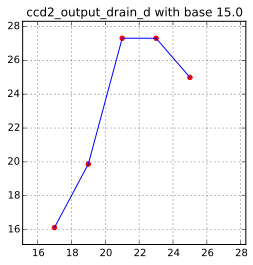

ccd2_parallel_high
-13.2


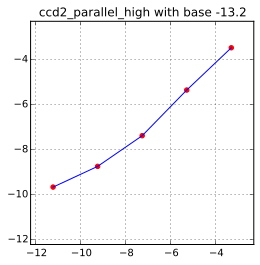

-12.32


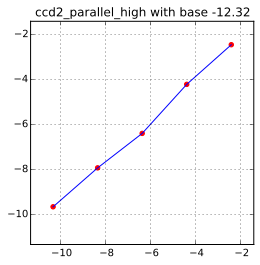

-11.44


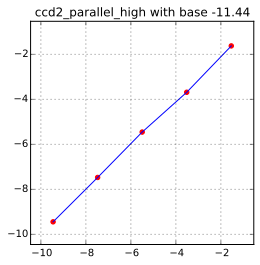

-10.56


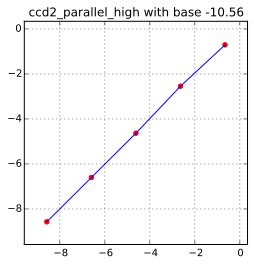

-9.68


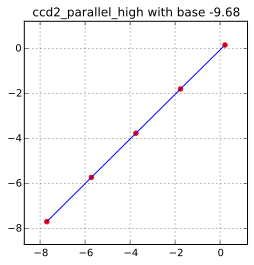

-8.8


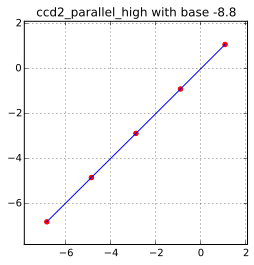

-7.92


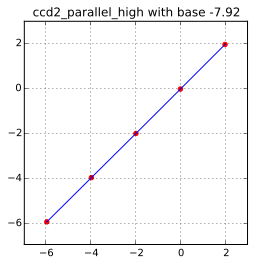

-7.04


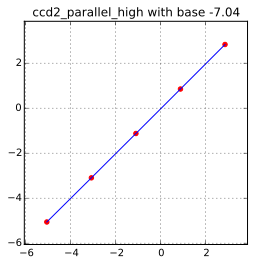

-6.16


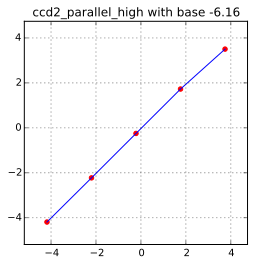

-5.28


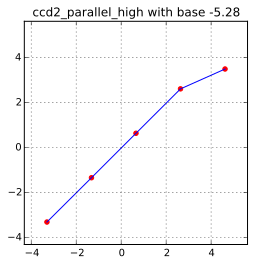

-4.4


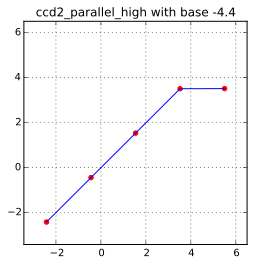

-3.52


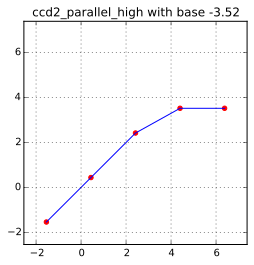

-2.64


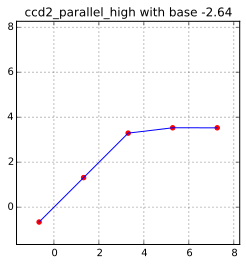

-1.76


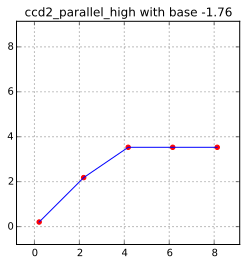

-0.88


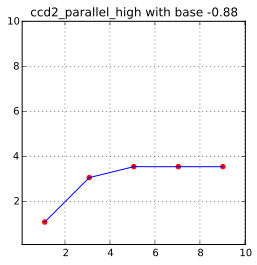

ccd2_reset_low
-10.3


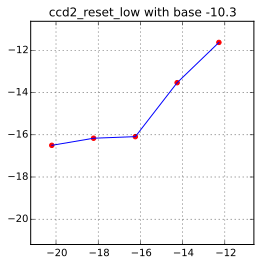

-8.61333333333


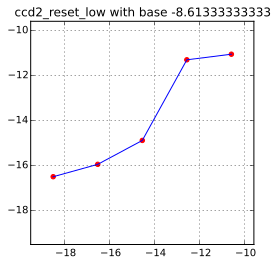

-6.92666666667


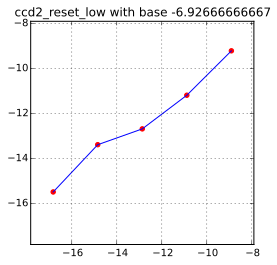

-5.24


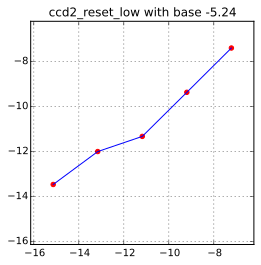

-3.55333333333


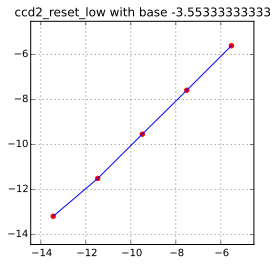

-1.86666666667


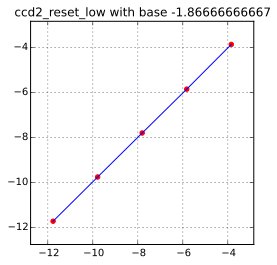

-0.18


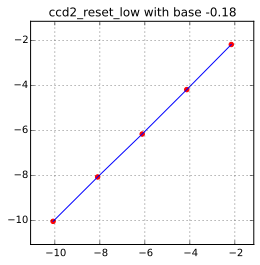

1.50666666667


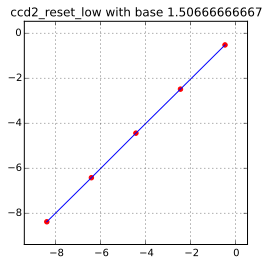

3.19333333333


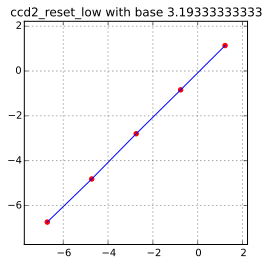

4.88


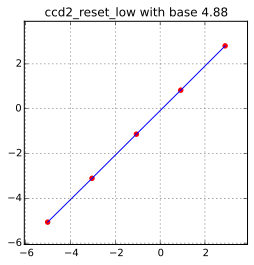

6.56666666667


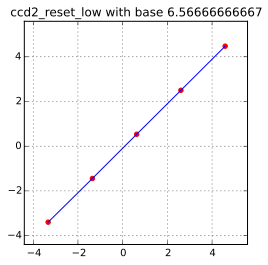

8.25333333333


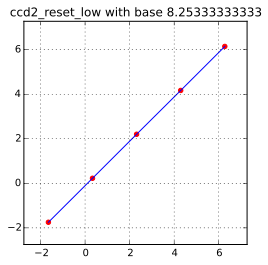

9.94


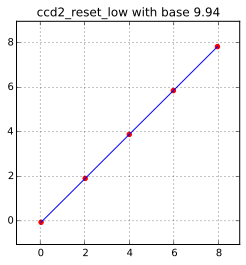

11.6266666667


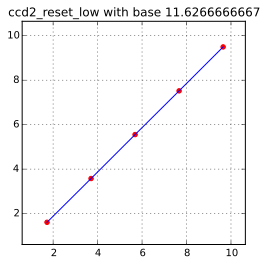

13.3133333333


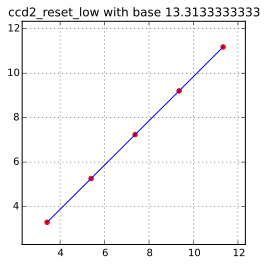

ccd2_serial_low
-10.3


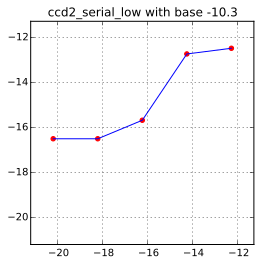

-8.61333333333


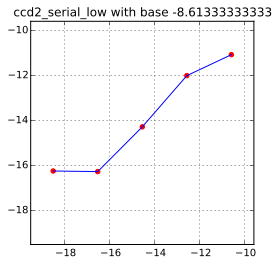

-6.92666666667


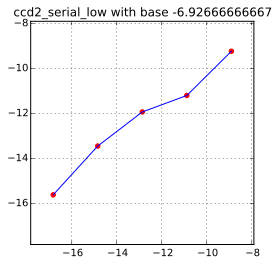

-5.24


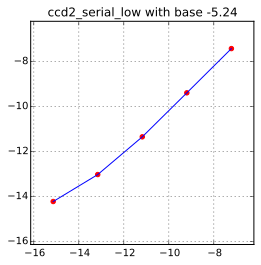

-3.55333333333


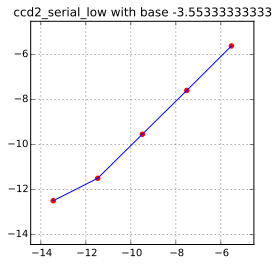

-1.86666666667


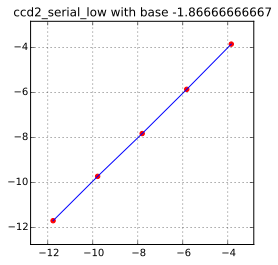

-0.18


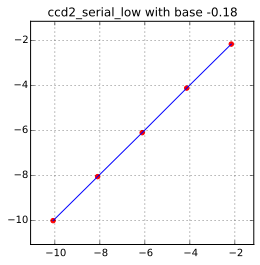

1.50666666667


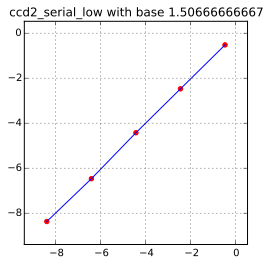

3.19333333333


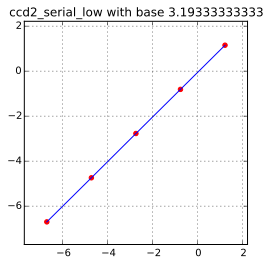

4.88


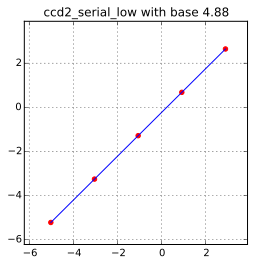

6.56666666667


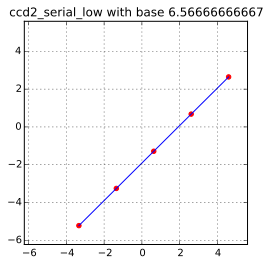

8.25333333333


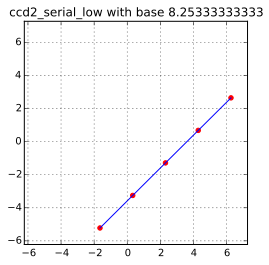

9.94


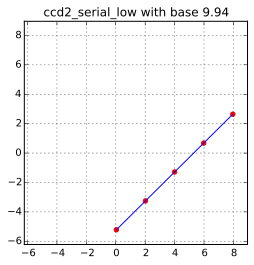

11.6266666667


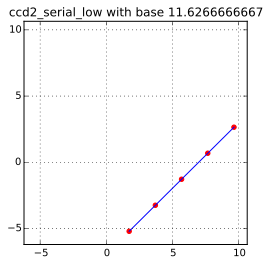

13.3133333333


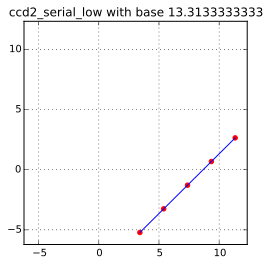

ccd3_output_drain_a
1.0


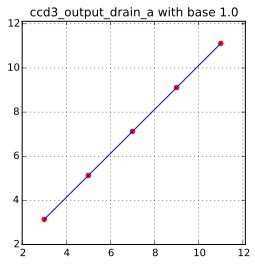

2.0


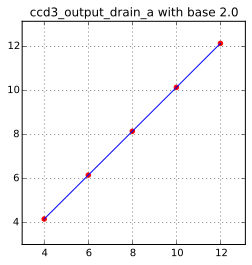

3.0


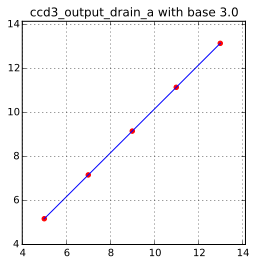

4.0


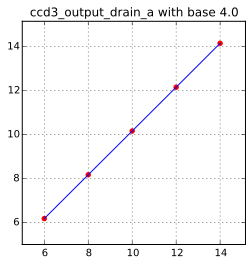

5.0


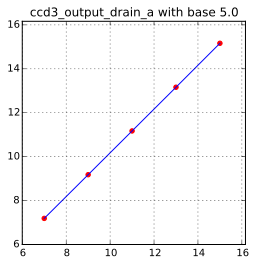

6.0


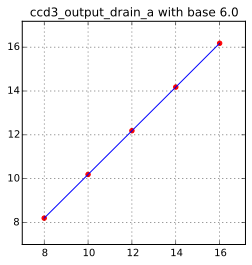

7.0


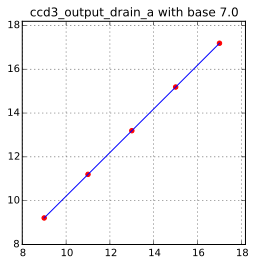

8.0


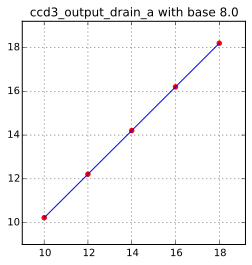

9.0


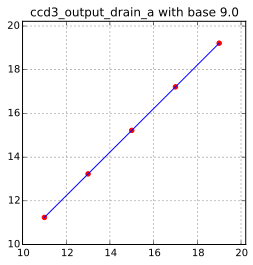

10.0


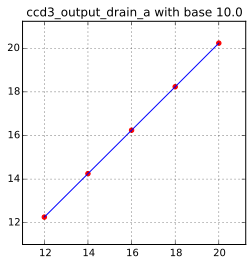

11.0


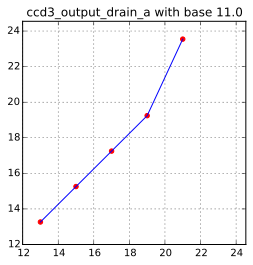

12.0


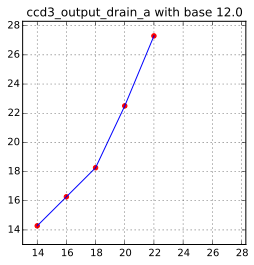

13.0


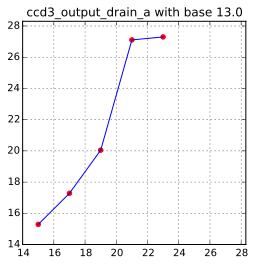

14.0


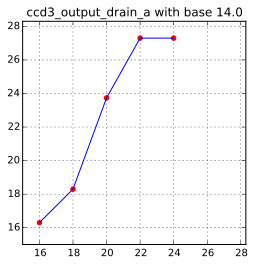

15.0


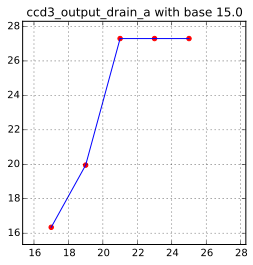

ccd3_output_drain_b
1.0


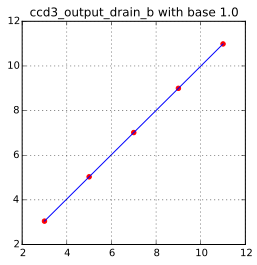

2.0


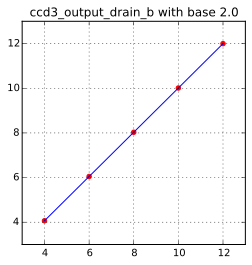

3.0


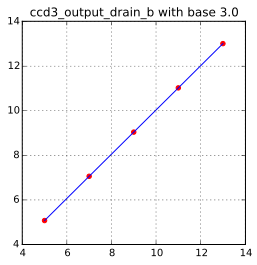

4.0


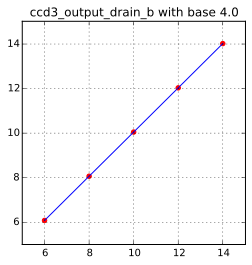

5.0


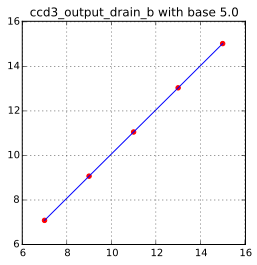

6.0


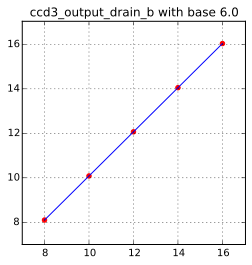

7.0


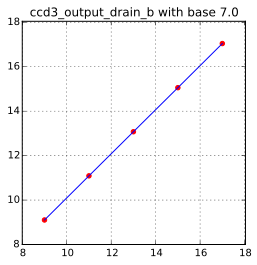

8.0


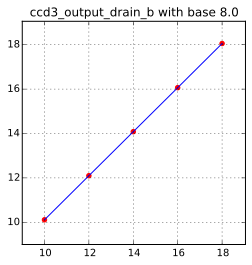

9.0


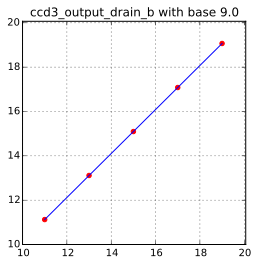

10.0


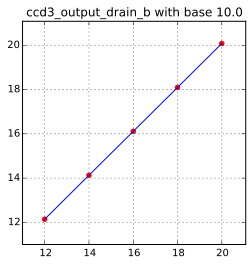

In [ ]:
# Plot the set vs. measured values of selected channels:
for nom in sorted(data.keys()):
    print nom
    for base_value in sorted(data[nom].keys()):
        print base_value
        X = data[nom][base_value]["X"]
        Y = data[nom][base_value]["Y"]
        ran = get_range_square(X,Y)
        pylab.ylim(ran)
        pylab.xlim(ran)
        pylab.grid(True)
        plt.axes().set_aspect(1)
        plt.title("{derived_param} with base {base}".format(
                derived_param=nom,
                base=base_value
            ))
        plt.scatter(X,Y,color='red')
        plt.plot(X,Y,color='blue')
        plt.show()